## Overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the delft3dfmpy python package.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook corresponds to version 1.2.3 of delft3fmpy, which is the latest version compatible with HyDAMO v13 data. Subsequent versions (2.*.*) will be based on DAMO2.2. Apart from the migration to this new data format, this version of delt3dfmpy is identical to v2.0.0.

To enable complete execution of this notebook, point these paths to the correct locations on your computer:

In [1]:
# Basis
import os
import sys
import shutil
import numpy as np
from platform import python_version

sys.path.append('../')       
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

Change these paths to access the data and to use all functionalities. dflowfm_path is needed to refine the 2D-grid.

In [2]:
# path to the package containing the dummy-data
data_path = os.path.abspath('../data')
print(data_path)

# path to dflowfm for refining the mesh 
dflowfm_path = r'D:\3640.20\software\dflowfm-x64-1.2.104.66827M'

# path to write the models
output_path = '../modellen\MGB_RRFM'

# path to DIMR for a correct run.bat file
dimr_path = r"C:\\Program Files\\Deltares\\D-HYDRO Suite 2022.03 1D2D\\plugins\\DeltaShell.Dimr\\kernels\\x64\\dimr\\scripts\\run_dimr.bat"

D:\3640.20\delft3dfmpy_master\delft3dfmpy\data


For python versions > 3.8, it is necessary to add a location for certain dll-files, otherwise gridgeom.dll fails, which is necessary for 2D-mesh generation.

In [3]:
if float('.'.join(python_version().split('.')[0:2])) >= 3.8:
    dll_path = r'C:\\Program Files\\Deltares\\D-HYDRO Suite 2022.03 1D2D\\plugins\\DeltaShell.Dimr\\kernels\\x64\\share\\bin'

### Read HYDAMO

Note: the data are also added in zipped format, to be unzipped in case of errors with the downloaded gml-files.

In the code section below the different parts or the HyDAMO gml are added. For more info on how to import the different elements from the HyDAMO gml, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing the HyDAMO files are:
- Read the objects from the GML file.
- Snap the structures to the branches
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number of features with a specfic name. If the name in the gml does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length o f10 characters, so probably a lot of column_mapping is necessary.

In [4]:
# initialize the class
hydamo = HyDAMO(extent_file=os.path.join(data_path,'gis/selectie_pilot.shp'))

# Branches
hydamo.branches.read_gml(os.path.join(data_path,'gml/hydroobject.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4

# read from GML
hydamo.crosssections.read_gml(os.path.join(data_path,data_path,'gml/dwarsprofiel.gml') , 
                              column_mapping={'ruwheidswaardelaag':'ruwheidswaarde'} ,
                              index_col='profielcode' ,
                              groupby_column='profielcode' , 
                              order_column='codevolgnummer')

hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections.drop('code', axis=1, inplace=True)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)

hydamo.parametrised_profiles.read_gml(os.path.join(data_path,'gml/NormGeparametriseerdProfiel.gml'), column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'})
hydamo.parametrised_profiles.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.parametrised_profiles.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Bridges
hydamo.bridges.read_gml(os.path.join(data_path,'gml/brug.gml'))
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# # Culverts
hydamo.culverts.read_gml(
   os.path.join(data_path,'gml/duikersifonhevel.gml'),
   index_col='code',
   column_mapping={'vormkoker': 'vormcode'},
   clip=hydamo.clipgeo
)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts.drop(duikers_rekentijd, axis=0, inplace=True)
hydamo.culverts.drop(duikers_gemalen, axis=0, inplace=True)

# Weirs (including universal weirs)
hydamo.weirs.read_gml(os.path.join(data_path,'gml/stuw.gml'))
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Orifices
hydamo.orifices.read_gml(os.path.join(data_path,'gml/onderspuier.gml'))
hydamo.orifices.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.orifices.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Closing devices / terugslagkleppen e.d.
hydamo.afsluitmiddel.read_gml(os.path.join(data_path,'gml/afsluitmiddel.gml'), index_col='code')

# Laterals (imported from shapefile)
hydamo.laterals.read_shp(os.path.join(data_path,'sobekdata/Sbk_S3BR_n.shp'), 
                         column_mapping={'ID        ': 'code', 
                                         'NAME      ': 'name',
                                         'X         ':'X',
                                         'Y         ':'Y'})
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=  500)
hydamo.laterals.dropna(axis=0, inplace=True, subset=['branch_offset'])

# Pumps
hydamo.gemalen.read_gml(os.path.join(data_path,'gml/gemaal.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml(os.path.join(data_path,'gml/pomp.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml(os.path.join(data_path,'gml/sturing.gml'), index_col='code')


Plot the model with branches, cross sections and structures. Note that compound structures are not plotted here as they do not have a geometry on their own; they are composed from their sub-structures that do have a geometry and are plotted here.

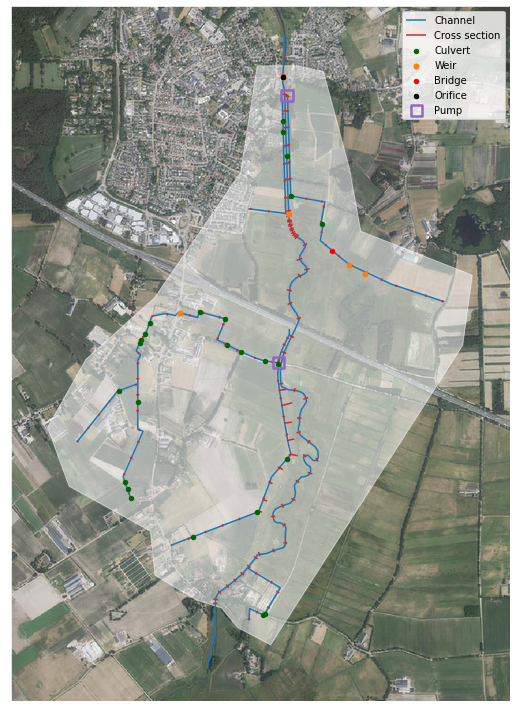

In [5]:
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread(os.path.join(data_path,'gis/achtergrond.png'))
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel')
hydamo.crosssections.plot(ax=ax, color='C3', label='Cross section')
hydamo.culverts.centroid.plot(ax=ax, color='darkgreen', label='Culvert', markersize=20, zorder=10)
hydamo.weirs.centroid.plot(ax=ax, color='C1', label='Weir', markersize=25, zorder=10)
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10)
hydamo.orifices.plot(ax=ax,color='black',label='Orifice',markersize=20,zorder=10)
hydamo.pumps.plot(
    ax=ax, color='C4', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)

ax.legend()

fig.tight_layout()

### Generate the D-HYDRO FM schematisation

#### Create the 1D network

Convert the geometries to D-HYDRO schematisation:

Start with importing the structures (from HyDAMO in this case), since the position of the structure can be used in defining the position of the 1d nodes. 

Structures can also be added without the HyDAMO imports. One weir is added manually, but this can be done for all implemented structures.

Note that for importing most structures multiple gml-files are needed. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found (either a YZ or a parametrised profile) the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section should contain a 'codegeralateerdobject' containing the ID of the universal weir.
 - culverts can also use an 'afsluitmiddel'; if one is coupled for a specific culvert and its type is 5 (terugslagklep) the flow direction is set 'positive' instead of 'both'. If the type is 4 (schuif), a valve will be implemented.
 - bridges need an associated crosssection (through the field 'codegerelateerdobject' in the cross-section); this can be either 'YZ' or 'parametrised'. The profiles are then processed so a suitable cross-section for a bridge is created;
 - pumps are composed from 'gemalen', 'pompen' and 'sturing'.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects (gemalen, pompen en sturing);
- bridges really need a profile (either 'crosssections' or 'parametrised_profiles' needs to contain a field 'codegerelateerdobject' that points to each bridge).

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

Note that orifices do not yet have an appropriate/definitive definition in HYDAMO. To be able to use it, we now use a separate GML-definition ('onderspuier") but possibly this will be integrated in the definition for weirs. To be continued.


In [6]:
dfmmodel = DFlowFMModel()

# Collect structures
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, hydamo.afsluitmiddel)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.orifices_from_hydamo(hydamo.orifices)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)

# Add a weir manually (equivalent functions exist for all structures):
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='riv_RS1_1810',
    chainage=950.0,
    crestlevel=8.00,
    crestwidth=7.5,
    corrcoeff=1.0    
)


2022-06-16 16:43:18,836 - delft3dfmpy.converters.hydamo_to_dflowfm - hydamo_to_dflowfm - INFO - Currently only simple weirs can be applied. From Hydamo the attributes 'laagstedoorstroomhoogte' and 'kruinbreedte' are used to define the weir dimensions.


INFO:delft3dfmpy.converters.hydamo_to_dflowfm:Currently only simple weirs can be applied. From Hydamo the attributes 'laagstedoorstroomhoogte' and 'kruinbreedte' are used to define the weir dimensions.


For some structures it is possible to set a time series on their controls. Currently these are:
- for weirs, the crestlevel
- for orifices, the lower edge level of the gate
- for culverts, the valve opening height.

IN D-HYDRO, the associated parameter names are, respectively, 'weir_crestLevel', 'orifice_gateLowerEdgeLevel' and 'culvert_valveOpeningHeight', but for the converter it is sufficient to use only part of these names, for example 'crest' (or crestlevel), 'gate' , or 'valve'. It is case insensitive and the full names is then implemented in D-HYDRO input.

The time series should be provided as a pandas series, with timesteps as indices.

Structure types should be 'weir', 'orifice' or 'culvert'; other structures are not supported yet.

Note: for calculations in the GUI it is not possible to provide time series, this has to be done through RTC-Tools. This functionality is therefore now commented out. It does work for DIMR-simulations though.

In [7]:
# #  test crestLevel time series for weir Weir_RS373-st1
# cl = pd.read_csv(data_path+'/sobekdata/crestlevel_weir_RS373-st1.csv', sep=';', index_col=0)
# cl.index = pd.to_datetime(cl.index)
# dfmmodel.external_forcings.set_structure_series('Weir_RS373-st1', 'weir','crest',cl)

In [8]:
# fig, ax = plt.subplots()
# ax.plot(
#     dfmmodel.external_forcings.structures.loc['Weir_RS373-st1']['time'],
#     dfmmodel.external_forcings.structures.loc['Weir_RS373-st1']['value'],
#     label='Crest level [m+NAP]'
# )
# ax.set_ylabel('Crest level [m+NAP]')
# ax.set_xlabel('Time [minutes since start]')

Compound structures are composed of other structures and will not be implemented as such in HyDAMO. D-Flow FM simply needs an ID for every compound structure and a list of structures it should be composed of. They should have the same location - so the converter snaps coordinates of subsequent sub-structures in a compound to the coordinates of the first sub-structure in the list.

To use, provide a list of ID's of compound structures, and along with, for every compound structure, a nested list of sub-structures. If there are many, these can be read from files (for example).

Note: the D-Hydro GUI does not read compound structures at the moment, but automatically merges objects at the exact same location into a compound. This is a known bug (version 2022.02).

In [9]:
# cmpnd_ids  = ['cmpnd_1']
# cmpnd_list = [['Orifice_Test1','UWeir_Test2']]
# dfmmodel.structures.io.compound_structures(cmpnd_ids, cmpnd_list)

After this add the branches and generate a grid.

In [10]:
# Create a 1D schematisation
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=40.0, seperate_structures=True)

2022-06-16 16:43:19,143 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.


2022-06-16 16:43:19,148 - delft3dfmpy.core.dfm - dfm - WARNING - Structures UWeir_Test2, Orifice_Test1 have the same location.


2022-06-16 16:43:19,152 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch riv_RS1_264 at: [0.0, 104.16550000000001, 348.33320917846794], due to the structures at [-0.001, 104.147, 104.184, 348.3342091784679].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch riv_RS1_264 at: [0.0, 104.16550000000001, 348.33320917846794], due to the structures at [-0.001, 104.147, 104.184, 348.3342091784679].


2022-06-16 16:43:19,160 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch riv_RS373_2442 at: [0.0, 258.68399999999997, 1369.5082649188546], due to the structures at [-0.001, 251.394, 265.974, 306.452, 374.187, 584.463, 722.824, 866.662, 1059.317, 1149.342, 1289.363, 1369.5092649188546].


INFO:delft3dfmpy.core.dfm:Added 1d mesh nodes on branch riv_RS373_2442 at: [0.0, 258.68399999999997, 1369.5082649188546], due to the structures at [-0.001, 251.394, 265.974, 306.452, 374.187, 584.463, 722.824, 866.662, 1059.317, 1149.342, 1289.363, 1369.5092649188546].


Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

In [11]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    dwarsprofielen=hydamo.crosssections,
    parametrised=hydamo.parametrised_profiles,
    branches=hydamo.branches
)

print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

2022-06-16 16:43:19,257 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of branches without cross section is: 16.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of branches without cross section is: 16.


2022-06-16 16:43:19,588 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 2.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 2.


2022-06-16 16:43:19,626 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of branches without cross section is: 1.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of branches without cross section is: 1.


2022-06-16 16:43:19,629 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of structures without cross section is: 2.


INFO:delft3dfmpy.io.dfmreader:Before adding the number of structures without cross section is: 2.


2022-06-16 16:43:19,658 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 1.


INFO:delft3dfmpy.io.dfmreader:After adding 'dwarsprofielen' the number of branches without cross section is: 1.


2022-06-16 16:43:19,671 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of structures without cross section is: 0.


INFO:delft3dfmpy.io.dfmreader:After adding 'normgeparametriseerd' the number of structures without cross section is: 0.


1 branches are still missing a cross section.
0 structures are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

In [12]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30, name='default')
dfmmodel.crosssections.set_default_definition(definition=default, shift=8.0)

#### Add a 2D mesh

To add a mesh, currently 2 options exist:

1) the converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

The 'refine'-method requires the dflowfm.exe executable. If this is not added to the system path, it can be provided in an optional argument to refine (dflowfm_path).

In [13]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

# Generate mesh within model bounds
# Generate mesh within model bounds
if float('.'.join(python_version().split('.')[0:2])) >= 3.8:
    os.add_dll_directory(dll_path)  
mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(10)
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=dflowfm_path)

# Determine the altitude from a digital elevation model
rasterpath = os.path.join(data_path,'rasters/dommel_25m.tif')
mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
# mesh.altitude_constant(15.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

2022-06-16 16:43:19,715 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Generating grid with cellsize 25 m and rotation 0 degrees.


INFO:delft3dfmpy.core.mesh2d:Generating grid with cellsize 25 m and rotation 0 degrees.


2022-06-16 16:43:19,782 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Selecting nodes within polygon.


INFO:delft3dfmpy.core.mesh2d:Selecting nodes within polygon.


2022-06-16 16:43:19,793 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Creating LineString for each edge.


INFO:delft3dfmpy.core.mesh2d:Creating LineString for each edge.


2022-06-16 16:43:20,208 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Checking for intersections.


INFO:delft3dfmpy.core.mesh2d:Checking for intersections.


2022-06-16 16:43:20,285 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Remove edges with only a single node within the clip area.


INFO:delft3dfmpy.core.mesh2d:Remove edges with only a single node within the clip area.


2022-06-16 16:43:24,559 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Creating GeoDataFrame of cell faces.


INFO:delft3dfmpy.core.mesh2d:Creating GeoDataFrame of cell faces.


2022-06-16 16:43:25,442 - delft3dfmpy.core.geometry - logging - INFO - Processing raster: 100 %


INFO:delft3dfmpy.core.geometry:Processing raster: 100 %


2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to activate)

In [14]:
#from dhydamo.core.mesh2d import Mesh2D
#mesh = Mesh2D()
# import the geometry
#mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
#mesh.altitude_from_raster(rasterpath)
# and add to the model
#dfmmodel.network.add_mesh2d(mesh)

#### Add the 1D-2D links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==False).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [15]:
del dfmmodel.network.links1d2d.faces2d[:]
del dfmmodel.network.links1d2d.nodes1d[:]
dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

2022-06-16 16:43:26,693 - delft3dfmpy.core.dfm - dfm - INFO - Generating links from 1d to 2d based on distance.


INFO:delft3dfmpy.core.dfm:Generating links from 1d to 2d based on distance.


In [16]:
dfmmodel.network.links1d2d.generate_2d_to_1d(max_distance=50, intersecting=False)
dfmmodel.network.links1d2d.remove_1d_endpoints()

2022-06-16 16:43:26,732 - delft3dfmpy.core.dfm - dfm - INFO - Generating links from 2d to 1d based on distance.


INFO:delft3dfmpy.core.dfm:Generating links from 2d to 1d based on distance.


2022-06-16 16:43:26,763 - delft3dfmpy.core.dfm - dfm - INFO - Creating GeoDataFrame of (4094) 2D cells.


INFO:delft3dfmpy.core.dfm:Creating GeoDataFrame of (4094) 2D cells.


2022-06-16 16:43:27,059 - delft3dfmpy.core.dfm - dfm - INFO - Determine intersecting or nearest branches.


INFO:delft3dfmpy.core.dfm:Determine intersecting or nearest branches.
c:\ProgramData\Anaconda3\envs\delft3dfmpy_extended\lib\site-packages\pygeos\measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)


2022-06-16 16:43:34,881 - delft3dfmpy.core.dfm - dfm - INFO - Remove links that cross another 2D cell.


INFO:delft3dfmpy.core.dfm:Remove links that cross another 2D cell.


Removing links crossing mult. cells:   0%|          | 0/4378 [00:00<?, ?it/s]

D:\3640.20\delft3dfmpy_master\delft3dfmpy\notebooks\..\delft3dfmpy\core\dfm.py:745: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroids = np.vstack([cell.mean(axis=0) for cell in np.array(self.mesh2d.get_faces())[idx]]).T


2022-06-16 16:43:45,840 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (141163.07, 393789.95) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (141163.07, 393789.95) because it is connected to an end-point.


2022-06-16 16:43:45,842 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (141163.07, 393789.95) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (141163.07, 393789.95) because it is connected to an end-point.


2022-06-16 16:43:45,845 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (141124.68, 395080.29) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (141124.68, 395080.29) because it is connected to an end-point.


2022-06-16 16:43:45,849 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (141124.68, 395080.29) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (141124.68, 395080.29) because it is connected to an end-point.


2022-06-16 16:43:45,852 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (139971.19, 393154.84) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (139971.19, 393154.84) because it is connected to an end-point.


2022-06-16 16:43:45,854 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (139971.19, 393154.84) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (139971.19, 393154.84) because it is connected to an end-point.


2022-06-16 16:43:45,858 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140933.51, 394463.93) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140933.51, 394463.93) because it is connected to an end-point.


2022-06-16 16:43:45,861 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140933.51, 394463.93) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140933.51, 394463.93) because it is connected to an end-point.


2022-06-16 16:43:45,863 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140936.86, 392153.14) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140936.86, 392153.14) because it is connected to an end-point.


2022-06-16 16:43:45,865 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140936.86, 392153.14) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140936.86, 392153.14) because it is connected to an end-point.


2022-06-16 16:43:45,868 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140274.55, 392836.60) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140274.55, 392836.60) because it is connected to an end-point.


2022-06-16 16:43:45,870 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140274.55, 392836.60) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140274.55, 392836.60) because it is connected to an end-point.


2022-06-16 16:43:45,873 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140498.32, 392574.61) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140498.32, 392574.61) because it is connected to an end-point.


2022-06-16 16:43:45,875 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (140498.32, 392574.61) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (140498.32, 392574.61) because it is connected to an end-point.


2022-06-16 16:43:45,878 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (142033.93, 393941.63) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (142033.93, 393941.63) because it is connected to an end-point.


2022-06-16 16:43:45,880 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (142033.93, 393941.63) because it is connected to an end-point.


INFO:delft3dfmpy.core.dfm:Removed link(s) from 1d node: (142033.93, 393941.63) because it is connected to an end-point.


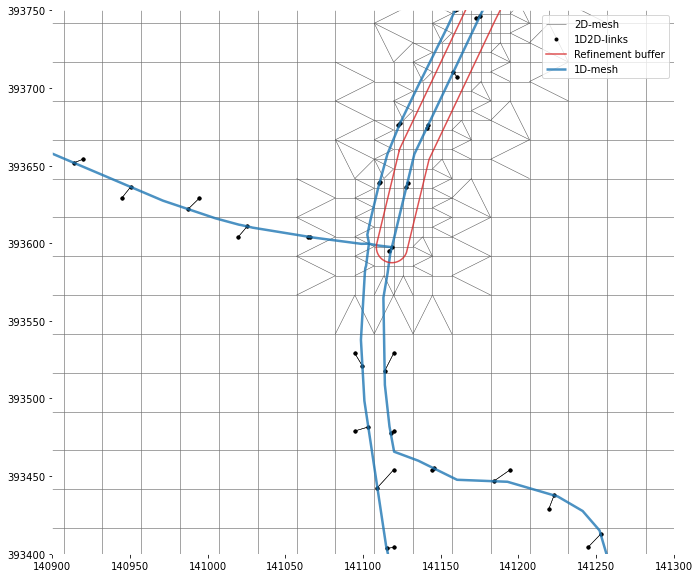

In [17]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(140900, 141300)
ax.set_ylim(393400, 393750);

### Boundary conditions for FM

Add boundary conditions to external forcings from a SOBEK time series.

In [18]:
bcs = pd.read_csv(os.path.join(data_path,'sobekdata/boundaryconditions.csv'), sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)

In [19]:
dfmmodel.external_forcings.add_boundary_condition(
    name='BC_flow_in',
    pt=(140712.056047, 391893.277878),
    bctype='discharge',
    series=bcs['Discharge']
)

dfmmodel.external_forcings.add_boundary_condition(
    name='BC_wlev_down',
    pt=(141133.788766, 395441.748424),
    bctype='waterlevel',
    series=bcs['Waterlevel']
)

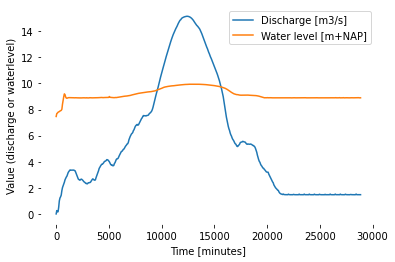

In [20]:
fig, ax = plt.subplots()

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_flow_in']['time'],
    dfmmodel.external_forcings.boundaries['BC_flow_in']['value'],
    label='Discharge [m3/s]'
)

ax.plot(
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['time'],
    dfmmodel.external_forcings.boundaries['BC_wlev_down']['value'],
    label='Water level [m+NAP]'
)

ax.set_ylabel('Value (discharge or waterlevel)')
ax.set_xlabel('Time [minutes]')

ax.legend();

### Initial conditions

There are four ways to set the initial conditions. First, global water level or depth can be set. In the example, we use a global water depth of 0.5 m, but we could also use the equivalent function "set_initial_waterlevel".

In [21]:
# Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

It is also possible to define a certain area, using a polygon, with alternative initial conditions (level or depth).

In [22]:
#init_special = gpd.read_file(data_path+'/GIS/init_waterlevel_special.shp')
#dfmmodel.external_forcings.set_initial_waterlevel(10.0, polygon=init_special.geometry[0], name='test_polygon',locationtype='2d')

### Lateral flow

Lateral flow can be obtained from the coupling with the RR-model, or by providing time series. Here, these are read from a Sobek model. In the coupling below, nodes that are not linked to a RR-boundary node are assumed to have a prescribed time series.

If a DFM-model is run offline, timeseries should be provided for all laterals.

In [23]:
###For adding the lateral inflow we import SOBEK results. To do so we use hkvsobekpy. For more info on this module, see: https://github.com/HKV-products-services/hkvsobekpy
# # Add the lateral inflows also from the SOBEK results. Naote that the column names in the his-file need to match
# # the id's of the imported lateral locations at the top of this notebook.
rehis = hkvsobekpy.read_his.ReadMetadata(os.path.join(data_path,'sobekdata/QLAT.HIS'), hia_file='auto')
param = [p for p in rehis.GetParameters() if 'disch' in p][0]
lateral_discharge = rehis.DataFrame().loc[:, param]
lateral_discharge.drop('lat_986', inplace=True, axis=1)

### Observation points

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates.

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore. Observation point coordinates can be definied eiher as an (x,y)-tuple or as a shapely Point-object.

In [24]:
from shapely.geometry import Point
dfmmodel.observation_points.add_points([Point((141150, 393700)),(141155, 393705)],['ObsPt1','ObsPt2'], locationTypes=['1d','1d'])

### Generating the RR-model

Catchments are provided as HyDAMO files and are read similarly as the FM files are. They can be GML or shape files. Note that in case of shapefiles column mapping is necessary because the column names are truncated. Required columns include 'code' as the ID and 'lateraleknoopcode' as the associated FM boundary node ID. 

Note that when catchments have a "MultiPolygon' geometry, the multipolygons are 'exploded' into single polygon geometries. A warning of this is isued, and a suffix is added to every polygons ID to prevent duplicates. This is the case for both GML and SHP input.

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.
 
At the moment, two options exist for the schematisation of the paved area:
 1) simple: the paved fraction of each catchment is modelled with a paved node, directly connected to catchments' boundary node
 <br>
 2) more complex: sewer area polygons and overflow points are used a input as well. For each sewer area, its paved  area is distributed over the overflows that are associated with it (via the column 'lateraleknoopcode') using the area-fraction (column 'fractie') of each overflow. In each cathment, paved area that does not intersect with a sewer area gets an unpaved node as in option (1).

In [25]:
# RR-catchments
hydamo.catchments.read_shp(os.path.join(data_path,'gml/afvoergebied_2.shp'), index_col='code', 
                           clip=None, column_mapping={'lateralekn' : 'lateraleknoopcode', 'administra':'administratiefgebied'})

Optionally, read also sewer areas and overflow locations. If sewer-areas are used, there must also be overflows and vice versa.

In [26]:
hydamo.sewer_areas.read_shp(os.path.join(data_path,'gml/rioleringsgebieden.shp'), index_col='code',clip=None, check_geotype=False)

hydamo.overflows.read_shp(os.path.join(data_path,'gml/overstorten.shp'), index_col='code', clip=None,           column_mapping={'codegerel':'codegerelateerdobject', 'Naam':'name' })
# snap the overflows to 1D branches
hydamo.overflows.snap_to_branch(hydamo.branches, snap_method='overal', maxdist= 5)


Other input data for RR can be fed by rasters (from which zonal statistics will be extracted) or spatially uniform default values. Three rasters are required: land use, soil type and surface elevation. For each land use type, the area within each catchment is calculated. Surface level is calculated as the median within the catchment, and the most-occurring soil type is used. In all rasters, a NODATA-value of -999 should be used.

An RR-model must first be initialized:

In [27]:
drrmodel = DFlowRRModel()

#### Unpaved nodes

The coding for the land use types needs to be as follows:<br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in m+NAP.

In [28]:
# all data and settings to create the RR-model
lu_file = os.path.join(data_path,'rasters/lgn250.tif')
ahn_file = os.path.join(data_path,'rasters/ahn_250.tif')
soil_file = os.path.join(data_path,'rasters/soiltypes250.tif')

Other parameters can be set by rasters (i.e. spatially distributed) or uniform. If a number is provided, the module will use this number for all catchments, if a string is provided it is interpreted as a raster file name. For unpaved nodes, these parameters are the storage on the surface, the infiltration capacity, and the initial ground water depth (in m below the surface). The parametrisation for Ernst is taken from a list of layer depths, where each depth is assigned the corresponding resistance from the list of layer_resistances. They need to be of equal length. The resistance value for flow from open water back to unpaved (infil_resistance) and the resistance for surface runoff (runoff_resistance) can also be determined here, but they are optional: if omitted, default values of 300 d-1 (cvi) and 1 d-1 (cvs) are adopted.

In [29]:
surface_storage = 10.0
infiltration_capacity = 100.0
initial_gwd = 0.4

runoff_resistance = 1.
infil_resistance = 300.
layer_depths = [0.0, 1.0, 2.0]
layer_resistances = [30,200,10000]

Fill the unpaved node with the corresponding ernst definition as follows. 

The argument 'meteo_areas' to 'unpaved_from_input' contains the polygons that correspond to a meteo-station: here these are identical to each catchment so each catchment gets its own station.  If there are many, small, catchments, it might be more appropriate to use, for instance, Thiessen polygons around gauges. For each catchment, the meteo-station is based on the 'meteo-area;-feature in which the centroid of the catchment falls.

The argument 'zonalstats_alltouched' is rather important. It defines the number of cells in the input rasters that are taken into account for each catchment. If the raster resolution is sufficiently high, its setting does not matter. In the case of coarse rasters, small catchments might end up with no nodes at all if the 'zonalstats_alltouched' is FALSE - it says that only cells of which the centoids are inside the polygon are taken into account. If it is TRUE, all cells that are touched by the catchment geometry are taken into account - i.e. some pixels might be counted multiple times. Note that to define average fluxes (meteo, seepage, storages) zonalstats_alltouched is TRUE by default. For elevation, land use and soil types it is FALSE by default, if the argument is omitted.

In [30]:
meteo_areas = hydamo.catchments

In [31]:
drrmodel.unpaved.io.unpaved_from_input(hydamo.catchments, lu_file, ahn_file, soil_file, surface_storage, infiltration_capacity, initial_gwd, meteo_areas, zonalstats_alltouched=True)
drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances,infiltration_resistance=infil_resistance, runoff_resistance=runoff_resistance)
# Or alternatively, to use default values of infiltration and runoff resistances:
#drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances)

In [32]:
hydamo.catchments.iloc[0].geometry.area

80514.64913781268

#### Paved 

Input for the paved nodes are land use -the area of the paved node is the area of class '14' in the provided land use map- and surface elevation. In addition, the following parameters can all be numbers (spatially uniform) or raster filenames:
- storage on the street (in mm)<br>
- storage in the sewer system (in mm)<br>
- capacity of the sewerpumps (in m3/s)<br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [33]:
street_storage = 10.0
sewer_storage =  os.path.join(data_path,'rasters/sewstor.tif')
pumpcapacity =  os.path.join(data_path,'rasters/pumpcap.tif')


To convert to a model definition, according to the more complex schematistion:

In [34]:
drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
                                    overflows=hydamo.overflows,
                                    sewer_areas=hydamo.sewer_areas,                                   
                                    landuse=lu_file, 
                                    surface_level=ahn_file,
                                    street_storage=street_storage,
                                    sewer_storage=sewer_storage,
                                    pump_capacity=pumpcapacity, 
                                    meteo_areas=meteo_areas,
                                    zonalstats_alltouched=True)

Or, according to the simplest approach:

In [35]:
drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
                                   landuse=lu_file, 
                                   surface_level=ahn_file,
                                   street_storage=street_storage,
                                   sewer_storage=sewer_storage,
                                   pump_capacity=pumpcapacity, 
                                   meteo_areas=meteo_areas)

2022-06-16 16:43:50,419 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS1_13_1


2022-06-16 16:43:50,479 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS1_14_1


2022-06-16 16:43:50,486 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS182_3_1_0


2022-06-16 16:43:50,489 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS182_3_1_1


2022-06-16 16:43:50,492 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS182_3_1_2


2022-06-16 16:43:50,494 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS182_3_1_3


2022-06-16 16:43:50,497 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS182_3_1_4


2022-06-16 16:43:50,546 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS373_1_0


2022-06-16 16:43:50,548 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS373_1_1


2022-06-16 16:43:50,570 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - WARNING - No rasterdata available for catchment riv_RS372_1_1_1


#### Greenhouse nodes

Input for the greenhouse nodes are (again) land use -the area of the paved node is the area of class '15' in the provided land use map- and surface elevation. In addition, the following parameter can be a number (spatially uniform) or a raster filename:
- storage on the roof <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [36]:
roof_storage = os.path.join(data_path,'rasters/roofstor.tif')

To convert to a model definition:

In [37]:
drrmodel.greenhouse.io.greenhouse_from_input(hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas, zonalstats_alltouched=True)

#### Open water

Input for the open water nodes are only land use -the area of the paved node is the area of class '13' in the provided land use map. 

The meteo-station is assigned in the same way as for unpaved nodes.

In [38]:
drrmodel.openwater.io.openwater_from_input(hydamo.catchments, lu_file, meteo_areas, zonalstats_alltouched=True)

#### Boundary nodes

Boundary nodes are assumed to be also included in the FM-model. For every catchment, the boundary identified by 'lateraleknoopocode' in the catchment definitition, is assumed to exist in the laterals. 

These nodes are created in the RR model with the same ID. 'drrmodel' is an argument because the function checks whether boundary nodes have a valid connection to anyo other node; other boundaries are removed. Overflows are optional and can be left out. If they are included, additional boundaries are created.

In [39]:
drrmodel.external_forcings.io.boundary_from_input(hydamo.laterals, hydamo.catchments, drrmodel, overflows=hydamo.overflows)

2022-06-16 16:43:51,866 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - Adding overflows to the boundary nodes.


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:Adding overflows to the boundary nodes.


Coupling between RR and FM must be online (parallel), not sequential. RR reads waterlevels from FM laterals and FM gets discharges from lateral nodes of discharge type 'realtime'. In the call to the function, the overflow locations are appended to the regular lateral locations. For lateral nodes for which no rr_boundary (catchment or overflow) exists, a time series from lateral_discharge is used.

In [40]:
dfmmodel.external_forcings.io.read_laterals(hydamo.laterals.append(hydamo.overflows), lateral_discharges=lateral_discharge, rr_boundaries=drrmodel.external_forcings.boundary_nodes)

#### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

Precipitation and evaporation are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved. For seepage, as the use of Metaswap-rasters is allowed, the unit is assumed to m3/grid cell/timestep.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.

IMPORTANT: time steps are extracted from the file names. Therefore, the names should cohere to some conditions:
The filename should consist of at least two parts, separated by underscores. The second part needs to contain time information, which should be formatted as YYYYMMDDHHMMSS (SS may be omitted). Or, for daily data YYYYMMDD.

For example: 'precip_20200605151500.tif'

In [41]:
seepage_folder =  os.path.join(data_path,'rasters/kwel')
precip_folder =  os.path.join(data_path,'rasters/precip')
evap_folder =  os.path.join(data_path,'rasters/evap')

In [42]:
drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder)
drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder)

Reading seepage files:   0%|          | 0/10 [00:00<?, ?it/s]

Reading precipitation files:   0%|          | 0/10 [00:00<?, ?it/s]

Reading evaporation files:   0%|          | 0/10 [00:00<?, ?it/s]

We need a function to be able to easily plot all nodes and links

In [43]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point
    geoms = []  
    links = []
    for i in dict.items():
        if 'ar' in i[1]:
            if np.sum([float(s) for s in i[1]['ar'].split(' ')])>0:
                geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
                links.append(LineString((Point(float(i[1]['px']),float(i[1]['py'])),
                                        Point(float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['px']),
                                              float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['py'])))))
        else: 
            geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
    return((gpd.GeoDataFrame(geoms,columns=['geometry'])),gpd.GeoDataFrame(links,columns=['geometry']))

Now all the nodes are filled. The topology is defined as follows: every catchment gets a maximum of four nodes (unpaved, paved, open water and greenhouse). If in the land use map, the appropriate land use does not occur in the catchment, no node is defined. The four nodes are plotted on a horizontal (west-east) line around the catchment centroid in the order of: openwater, unpaved, paved, greenhouse. Every node is connected with the lateral node of the catchnment using a RR-link. The files 3B_NOD.TP and 3B_LINK.TP are created describing this.

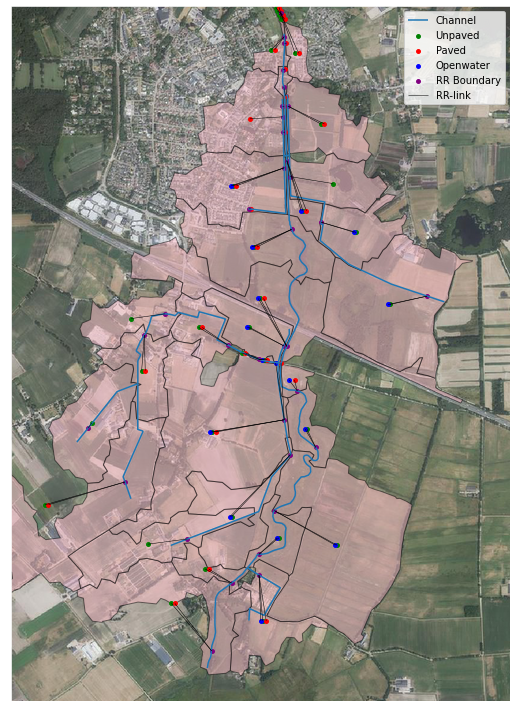

In [44]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread( os.path.join(data_path,'gis/achtergrond.png'))
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.catchments.plot(ax=ax,label='Catchments', edgecolor='black', facecolor="pink", alpha=0.5)
hydamo.branches.plot(ax=ax, label='Channel')
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(ax=ax,markersize=15,color='green',label='Unpaved')
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax,markersize=15,color='red',label='Paved')
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax,markersize=15,color='yellow',label='Greenhouse')
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax,markersize=15,color='blue',label='Openwater')
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(ax=ax, markersize=15, color='purple',label='RR Boundary')
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color='black',linewidth=0.5,label='RR-link')

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor='pink', edgecolor='black',alpha=0.5)
ax.legend(handles=handles.append(poly),labels=labels.append('Catchments'))
fig.tight_layout()

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. Note that both the GUI and Interaktor do not (yet) support RR, so the only way to carry out a coupled simulation is using DIMR.


In [45]:
# Runtime and output settings. Run the first six days of 2000, using a 1 hour timestep for RR.
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] =  2.0 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# for RR model
drrmodel.d3b_parameters['Timestepsize'] = 300
drrmodel.d3b_parameters['StartTime'] = "'2000/01/01;00:00:00'" # should be equal to refdate for D-HYDRO
drrmodel.d3b_parameters['EndTime'] = "'2000/01/07;00:00:00'"
drrmodel.d3b_parameters['RestartIn'] = 0
drrmodel.d3b_parameters['RestartOut'] = 0
drrmodel.d3b_parameters['RestartFileNamePrefix'] ='Test'
drrmodel.d3b_parameters['UnsaturatedZone'] = 1
drrmodel.d3b_parameters['UnpavedPercolationLikeSobek213']=-1
drrmodel.d3b_parameters['VolumeCheckFactorToCF']=100000
drrmodel.dimr_path = dimr_path

# Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir= output_path, name='moergestels_broek')
rr_writer = DFlowRRWriter(drrmodel, output_dir= output_path, name='moergestels_broek', wwtp=(142000.,394000.))

# Write as model
# The ldb is just for visualising in the interaktor - there is no RR component there.
fm_writer.objects_to_ldb()
fm_writer.write_all()
rr_writer.write_all()

Finished! Start the coupled model by clicking run.bat in the output model.